In [73]:
from math import ceil
from typing import List

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [74]:
INPUT = "./sample.jpg"
SAMPLES = [
    1.0,
    0.75,
    0.5,
    0.25
]
CONVERT_GRAYSCALE = False
REGION_SIZE = (16, 16)

In [75]:
def generate_images(input: str, samples: List[float], convert_grayscale: bool):
    img = cv2.imread(input)
    height, width, _ = img.shape

    if convert_grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for sample in samples:
        target_height = int(height * sample)
        target_width = int(width * sample)

        yield (sample, cv2.resize(img, (target_width, target_height)))

In [76]:
def get_features(img: np.ndarray, fast: cv2.FastFeatureDetector):
    return fast.detect(img, None)

In [77]:
fast: cv2.FastFeatureDetector = cv2.FastFeatureDetector_create()

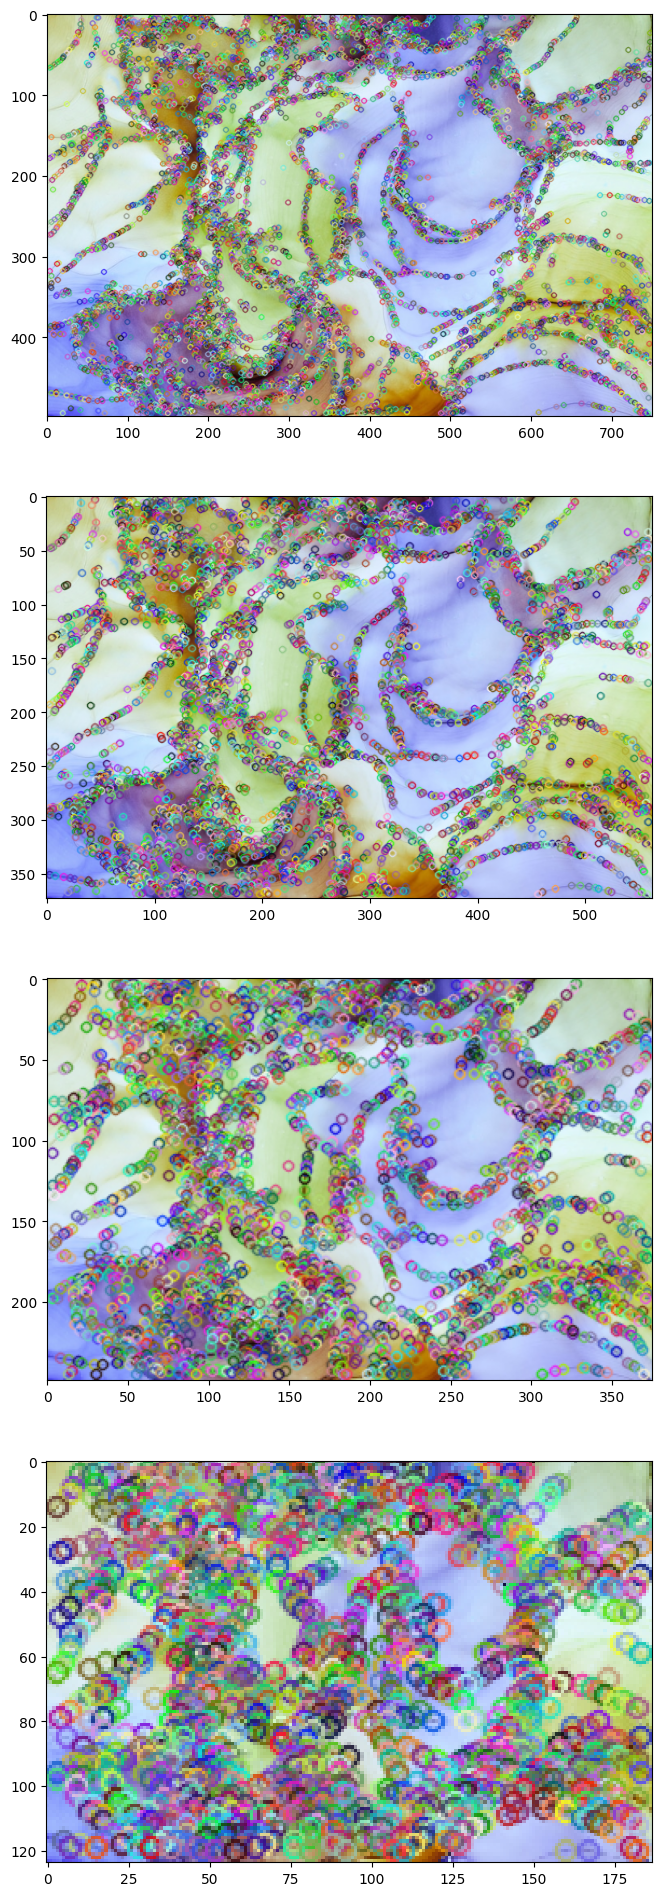

In [78]:
fig, axs = plt.subplots(nrows=len(SAMPLES), ncols=1, figsize=(12, 6*len(SAMPLES)))

for ax, (_, img) in zip(axs, generate_images(INPUT, SAMPLES, CONVERT_GRAYSCALE)):
    keypoints = get_features(img, fast)
    
    if img.shape == 2:
        height, width = img.shape
        feature_img = np.zeros((height, width, 3), dtype=np.uint8)

        feature_img[:, :, 0] = img
        feature_img[:, :, 1] = img
        feature_img[:, :, 2] = img
    else:
        feature_img = img.copy()

    cv2.drawKeypoints(feature_img, keypoints, feature_img)
    ax.imshow(feature_img)

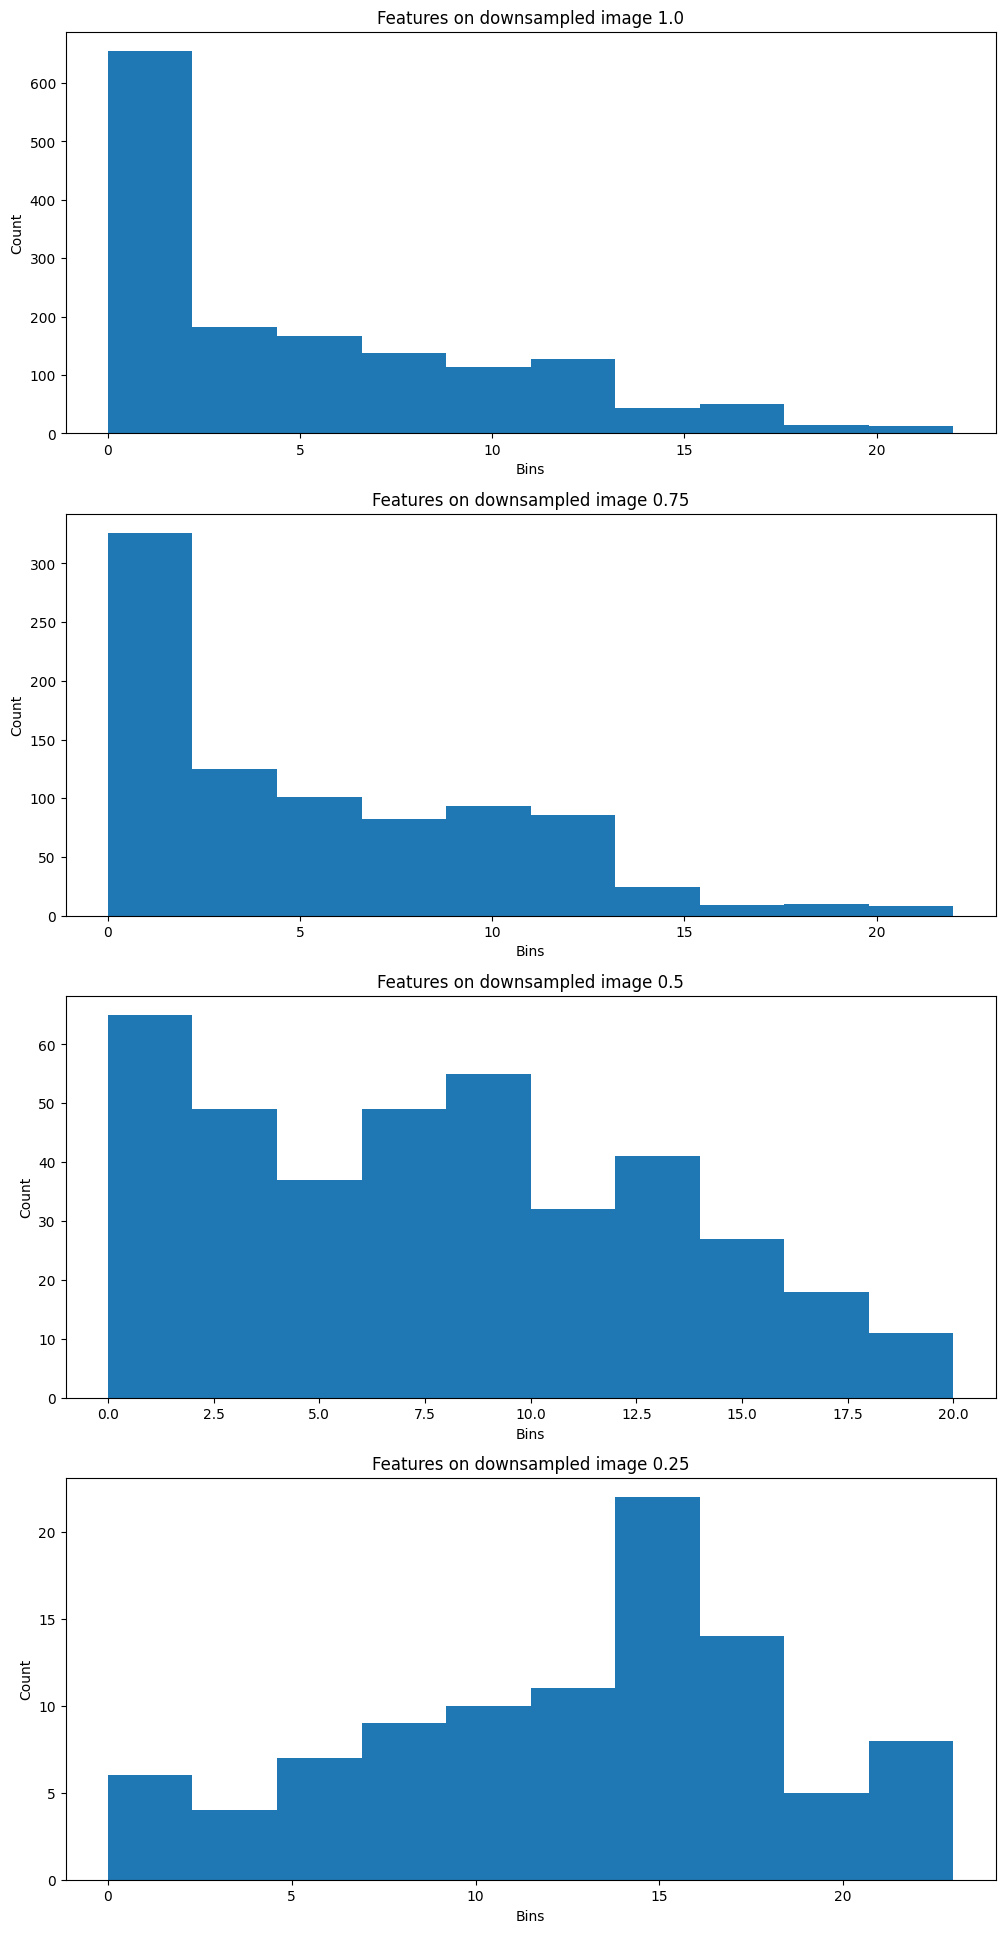

In [81]:
fig, axs = plt.subplots(nrows=len(SAMPLES), ncols=1, figsize=(12, 6*len(SAMPLES)))

for ax, (sample, img) in zip(axs, generate_images(INPUT, SAMPLES, CONVERT_GRAYSCALE)):
    keypoints = [k.pt for k in get_features(img, fast)]
    
    if CONVERT_GRAYSCALE:
        height, width = img.shape
    else:
        height, width, _ = img.shape

    region_width, region_height = REGION_SIZE
    region_width_count = float(width) / float(region_width)
    region_height_count = float(height) / float(region_height)

    keypoint_counts = []
    for height_idx in range(int(ceil(region_height_count))):
        start_height = height_idx * region_height
        end_height = min(height, start_height + region_height)

        for width_idx in range(int(ceil(region_width_count))):
            start_width = width_idx * region_width
            end_width = min(width, start_width + region_width)

            keypoints_in_region = [(w, h) for w, h in keypoints if start_width <= w < end_width and start_height <= h < end_height]

            full_area = float(region_width * region_height)
            current_area = float((end_height - start_height) * (end_width - start_width))

            keypoint_counts.append(float(len(keypoints_in_region)) / (current_area / full_area))

    ax.set_title(f"Features on downsampled image {sample}")
    ax.set(xlabel="Bins", ylabel="Count")
    ax.hist(keypoint_counts)